In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict

In [2]:
df_train = pd.read_csv('train_V2.csv', encoding='utf-8')
train_data = df_train.to_dict('records')
df_train.head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


## EDA

Group data by matchId.

In [3]:
match_idx_dict = defaultdict(lambda: [])

for i in range(len(train_data)):
    match_idx_dict[train_data[i]['matchId']].append(i) 

Match statistics.

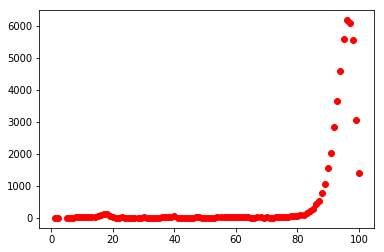

In [4]:
num_players_dict = defaultdict(int)
for indices in match_idx_dict.values():
    num_players_dict[len(indices)] += 1
    
plt.plot(num_players_dict.keys(), num_players_dict.values(), 'ro')

Take relevant columns to explore.

In [5]:
print(df_train.columns)

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')


In [6]:
rel_cols = set(df_train.columns)
rel_cols.remove('Id')
rel_cols.remove('groupId')
rel_cols.remove('matchId')
rel_cols.remove('matchType')
rel_cols.remove('roadKills')
rel_cols.remove('weaponsAcquired')

In [7]:
df_train_minimized = pd.DataFrame()
for c in rel_cols:
    df_train_minimized[c] = df_train[c]

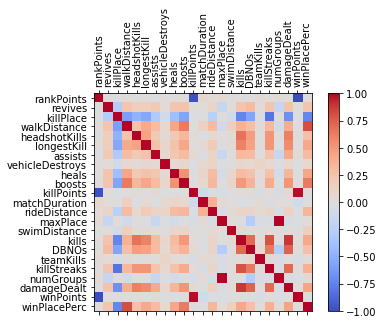

In [8]:
corr = df_train_minimized.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(df_train_minimized.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_train_minimized.columns)
ax.set_yticklabels(df_train_minimized.columns)
plt.show()

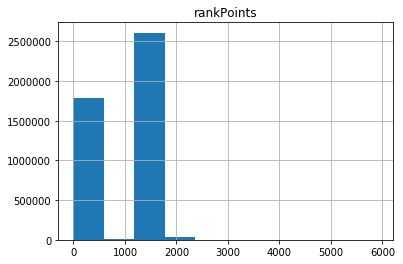

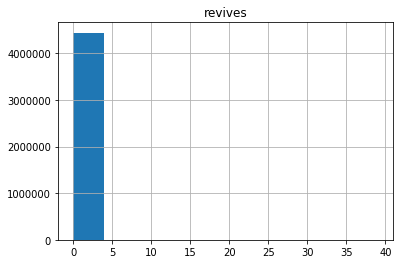

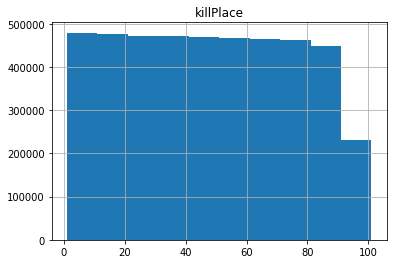

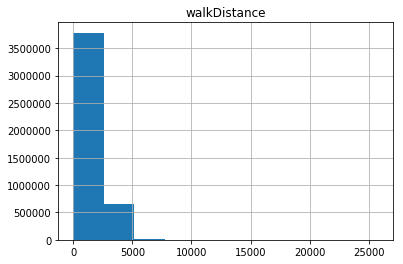

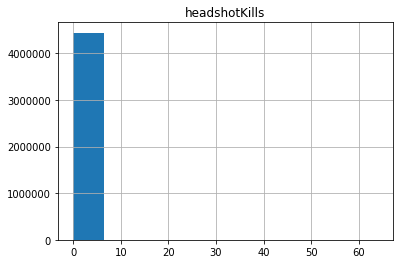

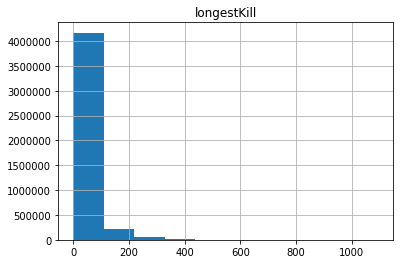

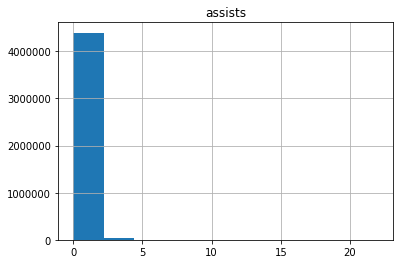

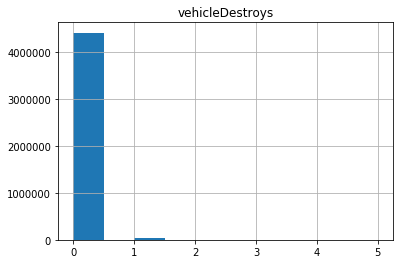

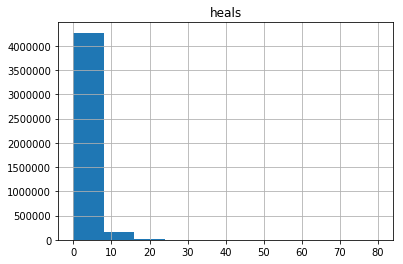

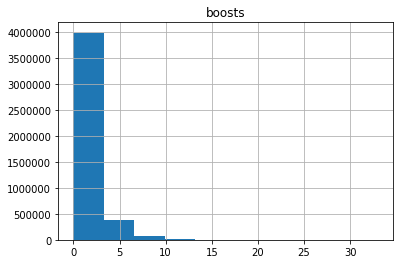

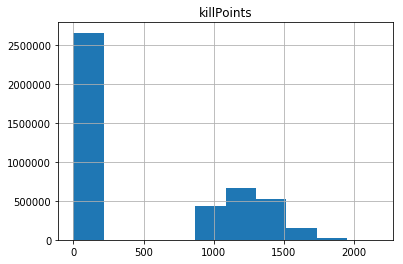

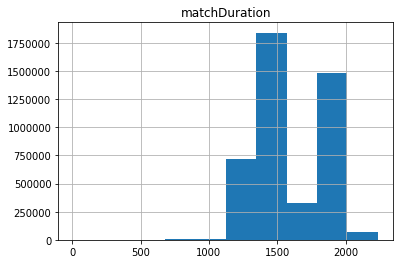

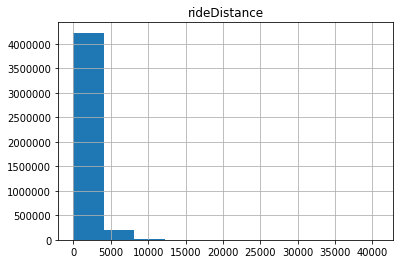

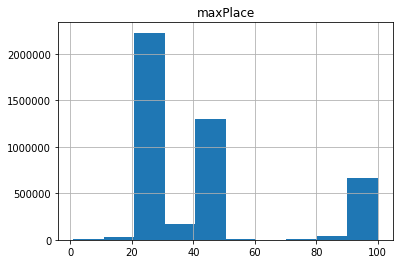

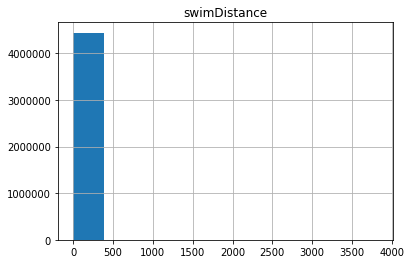

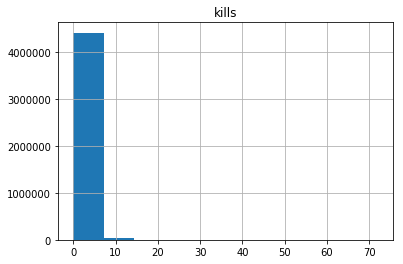

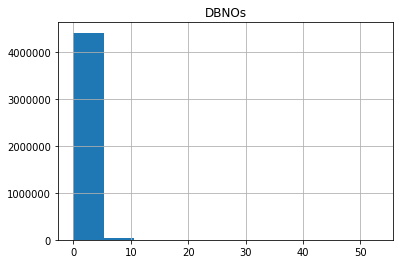

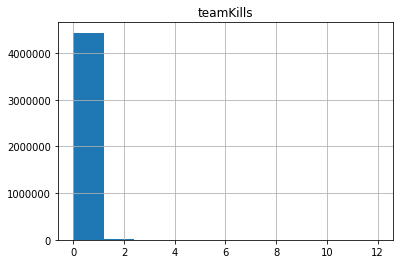

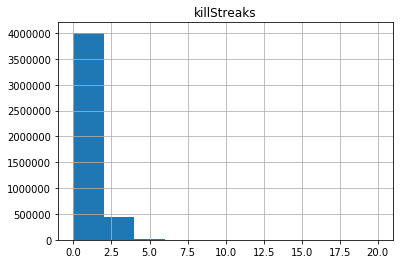

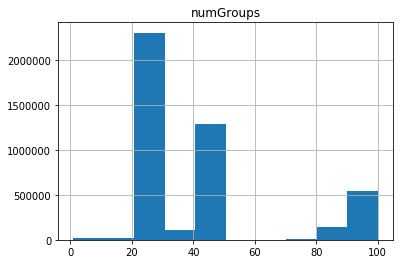

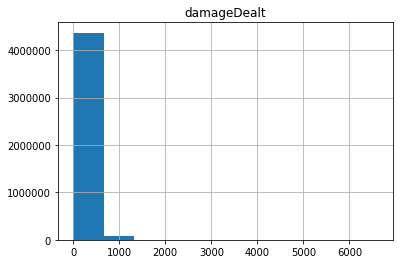

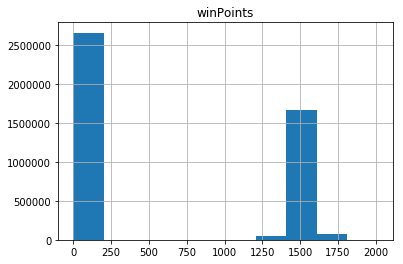

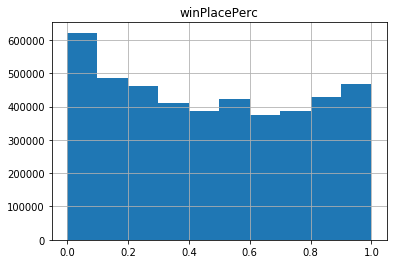

In [9]:
for c in rel_cols:
    df_train[c].hist()
    plt.title(c)
    plt.show()

Reduce range of x values so we can look at the data in more details.

In [10]:
df_train_set = pd.read_csv('train_set.csv', encoding='utf-8')
train_set = df_train_set.to_dict('records')

df_test_set = pd.read_csv('test_set.csv', encoding='utf-8')
test_set = df_test_set.to_dict('records')

df_valid_set = pd.read_csv('valid_set.csv', encoding='utf-8')
valid_set = df_valid_set.to_dict('records')

In [11]:
def fill_missing(data_set):
    for i in range(len(data_set)):
        if (np.isnan(data_set[i]['winPlacePerc'])):
            data_set[i]['winPlacePerc'] = 0
            
fill_missing(train_set)
fill_missing(test_set)
fill_missing(valid_set)

In [66]:
rel_cols = set(train_set[0].keys()) # Get columns
rel_cols.remove('Id')
rel_cols.remove('groupId')
rel_cols.remove('matchId')
#rel_cols.remove('matchType')
rel_cols.remove('roadKills')
rel_cols.remove('weaponsAcquired')
rel_cols.remove('winPlacePerc')
rel_cols.remove('Unnamed: 0')

In [78]:
matchTypes = ['solo', 'duo', 'squad', 'solo-fpp', 'duo-fpp', 'squad-fpp']
matchTypeID = defaultdict(int)
for i in range(len(matchTypes)):
    matchTypeID[matchTypes[i]] = i

def feature(datum):
    feature = []
    for c in rel_cols:
        if (c == 'matchType'):
            feature.append(matchTypeID[datum[c]])
        else:
            feature.append(datum[c])
    return feature

X_train = [feature(d) for d in train_set]
y_train = [d['winPlacePerc'] for d in train_set]

X_test = [feature(d) for d in test_set]
y_test = [d['winPlacePerc'] for d in test_set]

X_valid = [feature(d) for d in valid_set]
y_valid = [d['winPlacePerc'] for d in valid_set]

## Linear Regression

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [79]:
regr = LinearRegression()

# Train the model using the training sets
clf =regr.fit(X_train, y_train)
# score = clf.score(X_test, y_test)
# print "Score: ", score

y_pred = clf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae)

('MAE: ', 0.09459229808877176)


In [ ]:
print clf.

In [ ]:
# For Kaggle
df_kaggle_set = pd.read_csv('test_V2.csv', encoding='utf-8')
kaggle_set = df_kaggle_set.to_dict('records')

In [73]:
print "Started preparing submission file"

X_kaggle = [feature(d) for d in kaggle_set]
ids_kaggle = [d['Id']for d in kaggle_set]

predictions = clf.predict(X_kaggle)

print "Prediction ready"

Started preparing submission file
Prediction ready


In [74]:
print "Writing output file"

f = open("test_y.csv", "w")
f.write("Id,winPlacePerc\n")
for i in range(len(predictions)):
    id_kaggle = ids_kaggle[i]
    w = str(id_kaggle) + "," + str(predictions[i]) + "\n"
    f.write(w)
f.close()

print "Submission file is ready."

Writing output file
Submission file is ready.


## LightGBM

In [14]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [112]:
import datetime

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l2', 'l1'},
    'num_leaves': 350,
    'max_bin': 350,
    'num_iterations': 1000,
    'learning_rate': 0.05,
    'num_threads': 2,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 0
}

print(datetime.datetime.now())

lgb_data = lgb.Dataset(X_train + X_valid, y_train + y_valid)
lgb_train = lgb.train(params, lgb_data)
predictions = lgb_train.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print "MAE: ", mae

print(datetime.datetime.now())

2018-12-02 20:13:13.318684
MAE:  0.05748882698519035
2018-12-02 20:23:37.129222


In [109]:
# For Kaggle
df_kaggle_set = pd.read_csv('test_V2.csv', encoding='utf-8')
kaggle_set = df_kaggle_set.to_dict('records')

In [110]:
print "Started preparing submission file"

X_kaggle = [feature(d) for d in kaggle_set]
ids_kaggle = [d['Id']for d in kaggle_set]

predictions = lgb_train.predict(X_kaggle)

print "Prediction ready"

Started preparing submission file
Prediction ready


In [111]:
print "Writing output file"

f = open("test_y.csv", "w")
f.write("Id,winPlacePerc\n")
for i in range(len(predictions)):
    id_kaggle = ids_kaggle[i]
    w = str(id_kaggle) + "," + str(predictions[i]) + "\n"
    f.write(w)
f.close()

print "Submission file is ready."

Writing output file
Submission file is ready.
